In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-07-04 21:40:22


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [39]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.reco.params           import S12Params 
from   invisible_cities.reco.params           import CalibVectors
from   invisible_cities.reco.params           import DeconvParams
from   invisible_cities.reco.params           import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map

In [4]:
import invisible_cities.icaro.mpl_functions as mpl

In [5]:
import invisible_cities.reco.event_model as evm
from invisible_cities.core.ic_types import minmax

In [6]:
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si

In [7]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [8]:
run_number = 0
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [9]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [10]:
from invisible_cities.reco.dst_functions  import load_dst

In [11]:
event=0

In [12]:
filename = '/Users/jjgomezcadenas/Projects/ICDATA/MC/cs_rwf_1000.root.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 48000
nsipm: 1792
sipmwl: 1200



### Reconstruction Parameters

In [13]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 45000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 99 * units.mus,
                           max    = 101 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin  = False)

s2par = S12Params(time = minmax(min    = 101 * units.mus,
                           max    = 1199 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin  = True)

thresholds = ThresholdParams(thr_s1=0.2 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=3.5*units.pes,
                      thr_SIPM=10*units.pes)



#### Deconvolution

In [14]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

#### csum

In [15]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

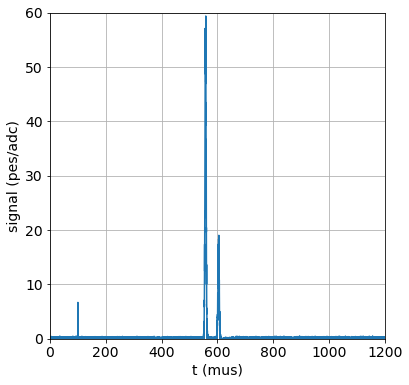

In [16]:
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    0,
                        signal_max =  60,
                        figsize=(6,6))

#### S1 and S2

In [17]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)

In [18]:
s1d = cpf.find_s12(csum, s1_indx, **s1par._asdict())
s2d = cpf.find_s12(csum, s2_indx, **s2par._asdict())

In [19]:
s1dd = cpf.find_S12(csum, s1_indx, **s1par._asdict())
s2dd = cpf.find_S12(csum, s2_indx, **s2par._asdict())

In [20]:
s1d

{0: [array([ 100050.,  100075.,  100100.,  100125.,  100150.,  100175.,
          100200.,  100225.,  100250.]),
  array([ 1.91426986,  4.42765828,  6.69145339,  6.22994729,  3.53204121,
          1.99270309,  1.82356258,  1.41285893,  0.94242468])]}

In [21]:
s1dd

{0: [array([ 100050.,  100075.,  100100.,  100125.,  100150.,  100175.,
          100200.,  100225.,  100250.]),
  array([ 1.91426986,  4.42765828,  6.69145339,  6.22994729,  3.53204121,
          1.99270309,  1.82356258,  1.41285893,  0.94242468])]}

In [22]:
s1 = S1(s1d)

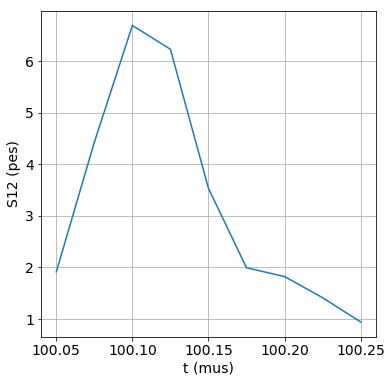

In [23]:
plot_s12(s1)

In [24]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 9 width =      0.2 mus , energy =     29.0 pes
        height =      6.7 pes tmin-tmax = minmax(min=100.05, max=100.25) mus  

In [25]:
print(s1)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 9 width =      0.2 mus , energy =     29.0 pes
        height =      6.7 pes tmin-tmax = minmax(min=100.05, max=100.25) mus  



In [26]:
s2 = S2(s2d)

In [27]:
print(s2)

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 14 width =     12.3 mus , energy =  11685.8 pes
        height =   2109.0 pes tmin-tmax = minmax(min=551.875, max=564.2) mus  
peak number = 1: Peak(samples = 12 width =     10.5 mus , energy =   3621.4 pes
        height =    635.5 pes tmin-tmax = minmax(min=598.9375, max=609.4125) mus  



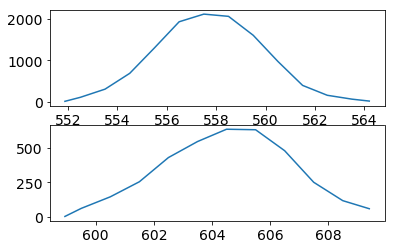

In [28]:
plot_s12(s2)

#### S2Si

In [29]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)

In [30]:
s2sid = cpf.sipm_s2_dict(sipmzs, s2d, thr=thresholds.thr_SIPM)

In [31]:
s2sid

{0: {1122: array([ 0.        ,  0.        ,  0.        ,  5.03221248,  0.        ,
          0.        ,  0.        ,  6.00405339,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ]),
  1123: array([  0.        ,   0.        ,   0.        ,   6.05928445,
          10.79021289,   8.01079243,   8.06992904,   5.05396215,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ]),
  1124: array([ 0.        ,  0.        ,  0.        ,  0.        ,  6.12187109,
          0.        ,  6.81023154,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ]),
  1130: array([  0.        ,   0.        ,   0.        ,  11.94980424,
          14.84377785,   8.93000568,  15.97620231,  16.91988936,
           6.91680665,   3.77118315,   0.        ,   0.        ,
           0.        ,   0.        ]),
  1131: array([  0.        ,   4.90851421,   0.        ,  11.01832136,
          18

In [32]:
#s2sid = cpf.sipm_s2_dict(SIPM, s2d, thr=thresholds.thr_SIPM)

In [33]:
s2si = S2Si(s2d, s2sid)

In [34]:
s2si

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 14 width =     12.3 mus , energy =  11685.8 pes
        height =   2109.0 pes tmin-tmax = minmax(min=551.875, max=564.2) mus  
peak number = 1: Peak(samples = 12 width =     10.5 mus , energy =   3621.4 pes
        height =    635.5 pes tmin-tmax = minmax(min=598.9375, max=609.4125) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1122, 1123, 1124, 1130, 1131, 1132, 1138, 1139, 1140, 1147)

peak number = 1: nsipm in peak = (757, 1134, 1142, 1313, 1331)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1122
    sipm waveform (zs) = Peak(samples = 2 width =      4.0 mus , energy =     11.0 pes
        height =      6.0 pes tmin-tmax = minmax(min=554.5, max=558.5) mus 
peak number = 0: sipm number = 1123
    sipm waveform (zs) = Peak(samples = 5 width =     

In [36]:
s2si.number_of_peaks

2

In [37]:
s2si.sipms_in_peak(0)

(1122, 1123, 1124, 1130, 1131, 1132, 1138, 1139, 1140, 1147)

In [38]:
s2si.sipms_in_peak(1)

(757, 1134, 1142, 1313, 1331)

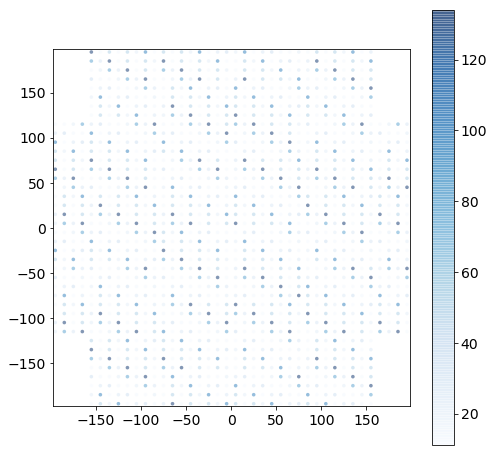

In [41]:
plot_s2si_map(s2si)

In [42]:
trk = [(sipm_no, xs[sipm_no], ys[sipm_no])
        for sipm_no in s2si.sipms_in_peak(0)]

In [43]:
trk

[(1122, 45.0, -55.0),
 (1123, 45.0, -45.0),
 (1124, 45.0, -35.0),
 (1130, 55.0, -55.0),
 (1131, 55.0, -45.0),
 (1132, 55.0, -35.0),
 (1138, 65.0, -55.0),
 (1139, 65.0, -45.0),
 (1140, 65.0, -35.0),
 (1147, 75.0, -45.0)]

In [44]:
trk = [(sipm_no, xs[sipm_no], ys[sipm_no])
        for sipm_no in s2si.sipms_in_peak(1)]

In [45]:
trk

[(757, -15.0, -25.0),
 (1134, 55.0, -15.0),
 (1142, 65.0, -15.0),
 (1313, 125.0, 135.0),
 (1331, 145.0, 155.0)]